In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import plotly.express as px

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
# g_palette = create_palette(8000)
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

True


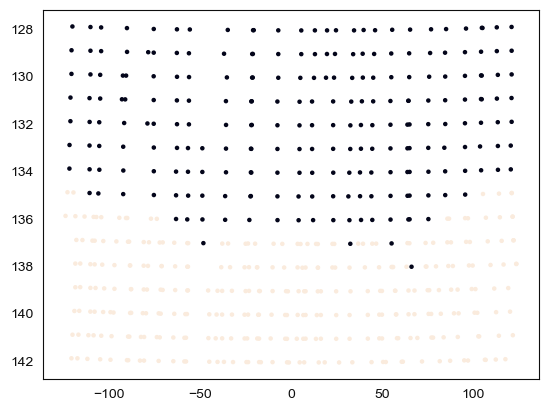

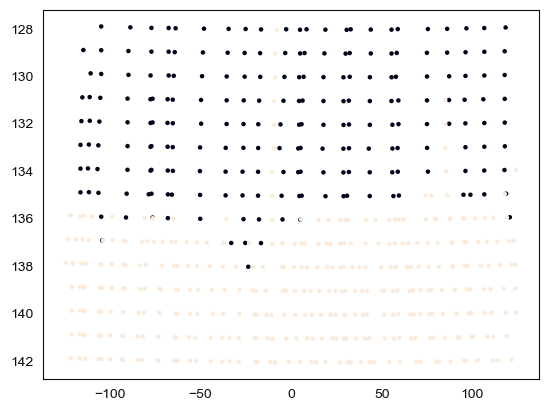

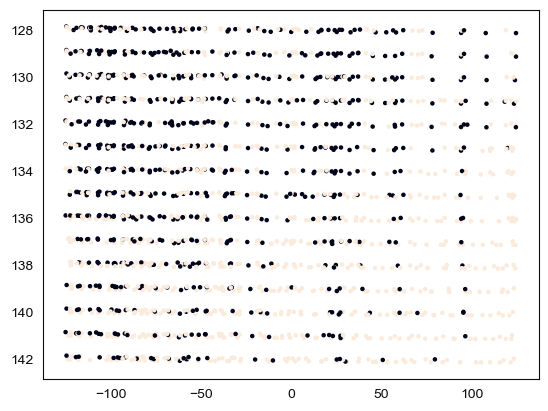

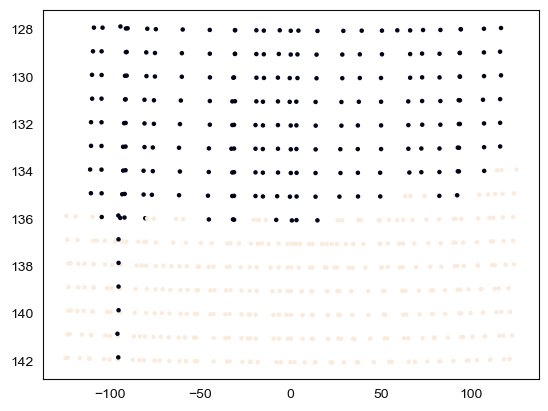

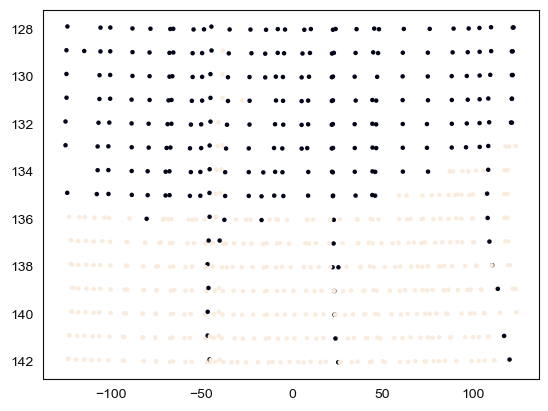

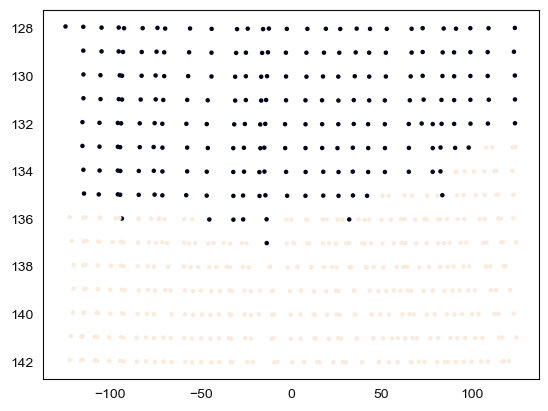

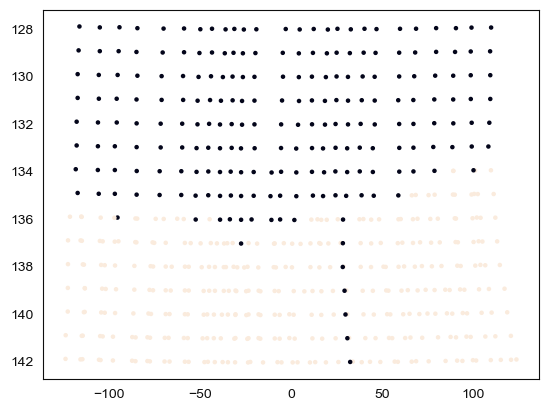

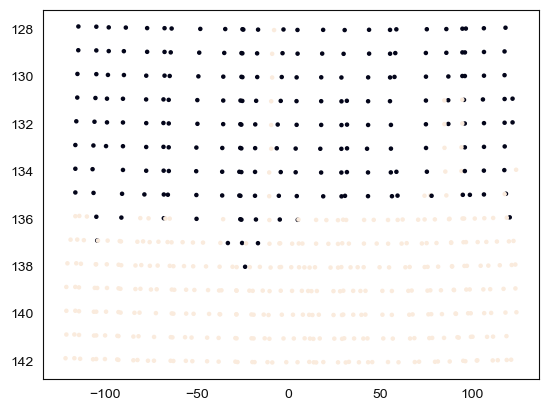

True


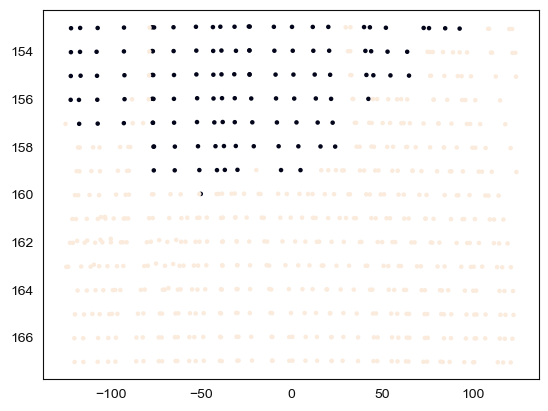

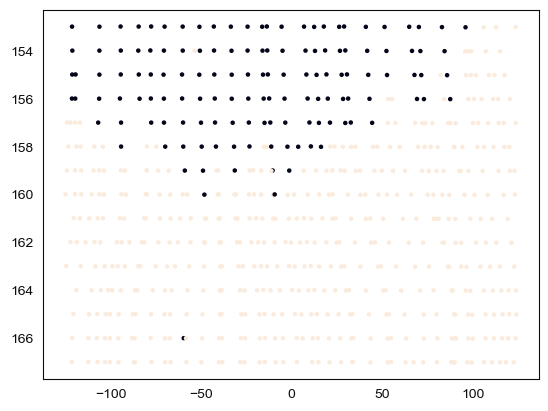

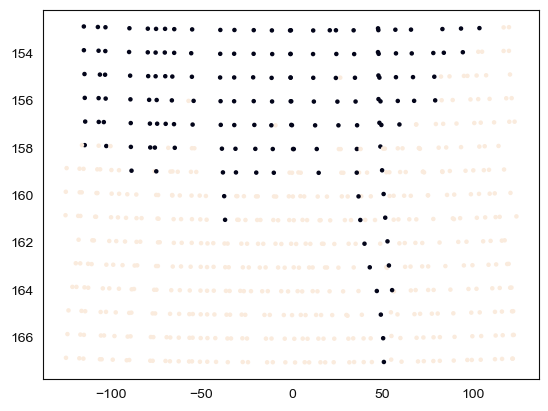

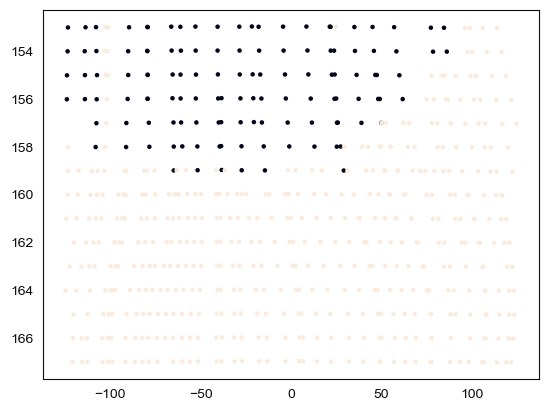

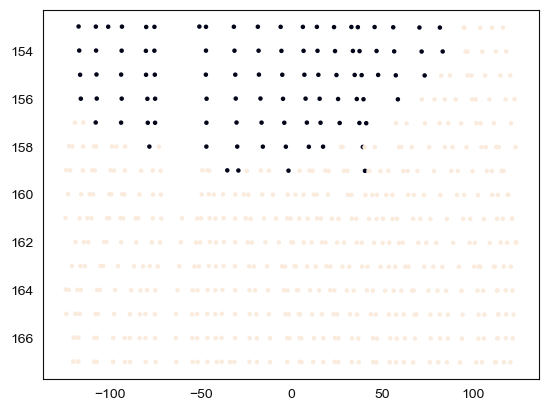

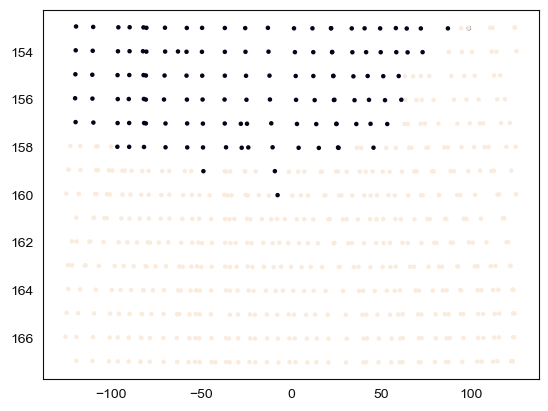

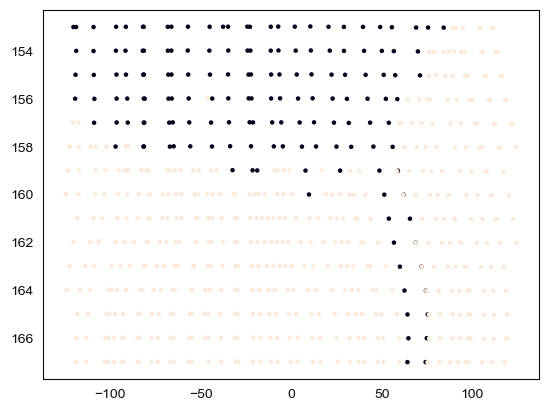

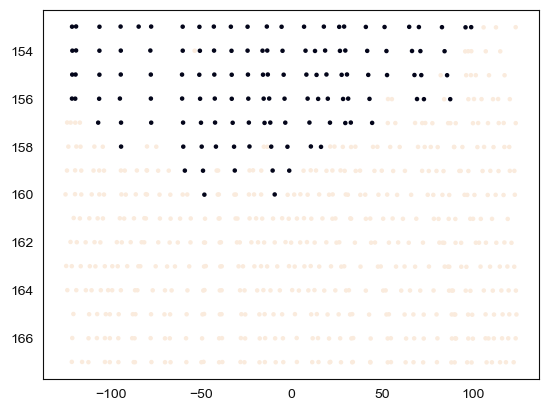

True


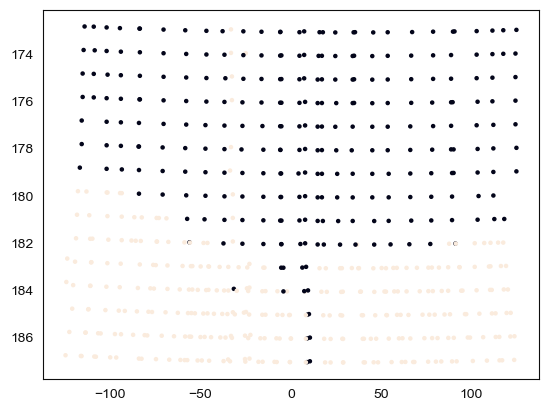

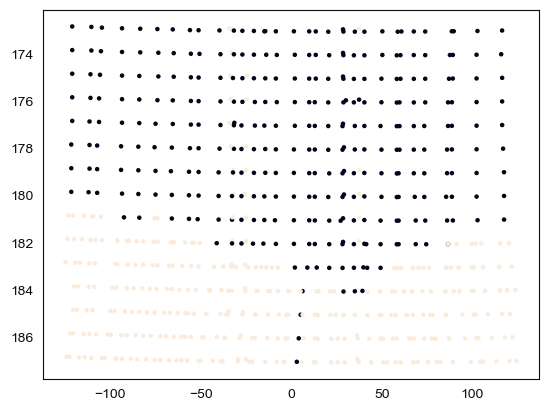

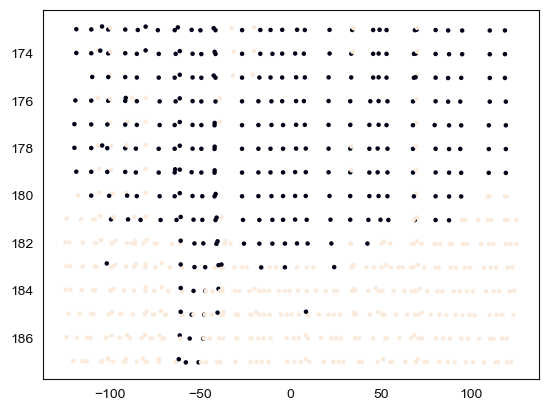

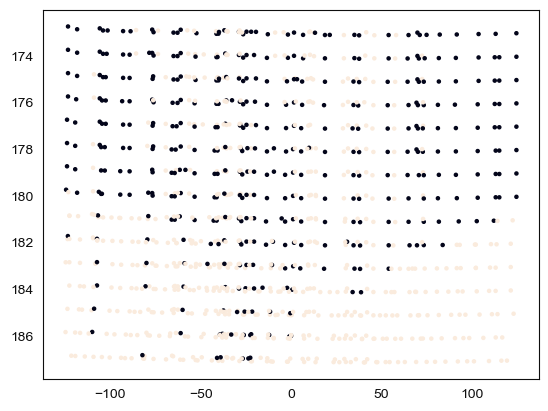

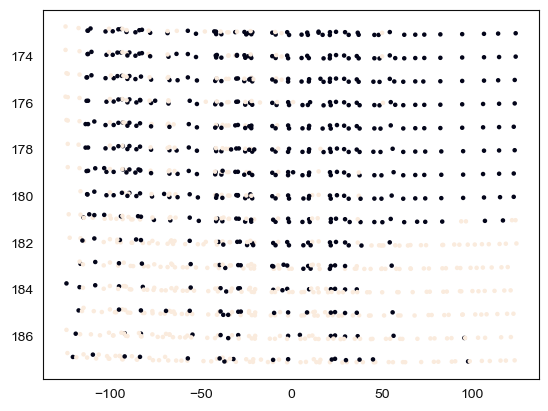

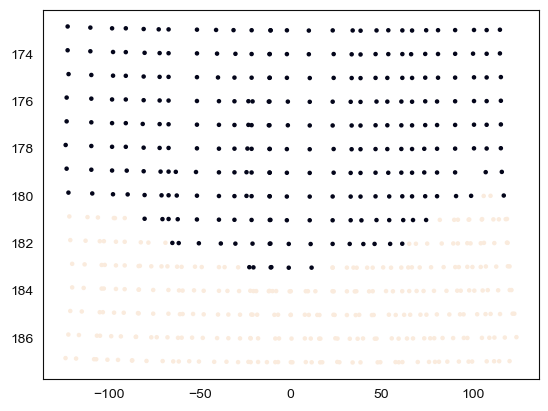

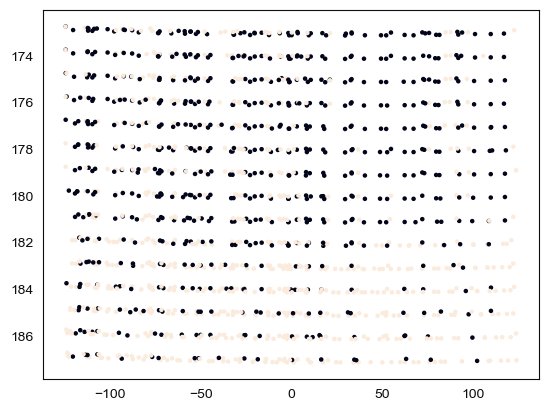

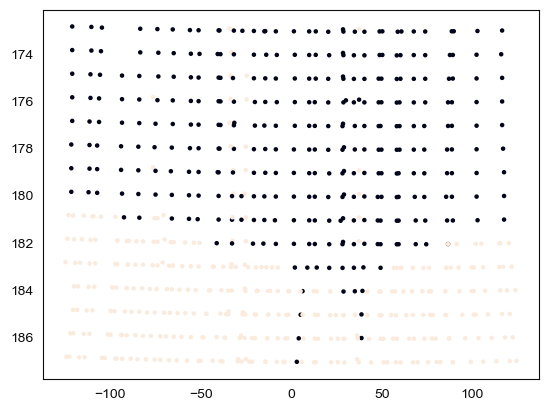

In [3]:
import napari

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

nc13_frame = [
    205,
    228, 
    248
]

nc13_frame = [
    135, 160, 180
]

H = 250
W = 15
trang = 8

# viewer = napari.Viewer()

for i, source in enumerate(sources):

    source_path = Path(source)
    print(source_path.exists())
    spots_df = pd.read_csv(source_path)
    save_path = r"D:\OneDrive - Princeton University\Lab Meetings\stas_duke"
    
    this_t = nc13_frame[i]
    
    # spots_df = [spots_df["FRAME"] < this_t + 10]
    
    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0]
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    # rotation transformation puts the AP axis in the y direction:
    axes = pca.components_
    rotation_matrix = np.array([axes[1], axes[0], axes[2]])
    pos_rot = pos @ rotation_matrix.T
    
    cycle_start_time = spots_df.groupby("tracklet_id")["FRAME"].min()
    spots_df["cycle_start_time"] = spots_df["tracklet_id"].map(cycle_start_time)
    
    for angle in np.linspace(0, 360, 8):
        
        pos_rot = pos_rot @ np.array([
            [np.cos(angle), 0, -np.sin(angle)],
            [0, 1, 0],
            [np.sin(angle), 0, np.cos(angle)],
        ])
    
        spots_df["rotated_x"] = pos_rot[:, 2] - np.mean(pos_rot[:, 2])
        spots_df["rotated_y"] = pos_rot[:, 1] - np.mean(pos_rot[:, 1])
        spots_df["rotated_z"] = pos_rot[:, 0] - np.mean(pos_rot[:, 0])
        # 
        # plt.hist(spots_df.groupby("tracklet_id")["FRAME"].min(), bins=100)
        # plt.show()
        
        z_band = spots_df["rotated_z"] > 0
        y_band = np.abs(spots_df["rotated_y"]) - H/2 < 0
        x_band = np.abs(spots_df["rotated_x"]) - W/2 < 0
        t_band = np.abs(spots_df["FRAME"] - this_t) - trang < 0
        band_pts = spots_df[z_band & y_band & x_band & t_band]
                
        y = band_pts["FRAME"] + (band_pts["rotated_z"] - np.mean(band_pts["rotated_z"])) / 100
        
        plt.scatter(band_pts["rotated_y"], y, c=band_pts["cycle_start_time"] > this_t - 15, s=5)
        # invert y axis
        plt.gca().invert_yaxis()
        plt.show()
    
    # color = np.array([palette["green"] if x else palette["pink"] for x in band_pts["cycle_start_time"] > this_t - 15])
    # print(color)
    # viewer.add_points(band_pts[["FRAME", "rotated_x", "rotated_y", "rotated_z"]], size=7, face_color=color, name=f"source_{i}")
    # 
# napari.run()
    
    

True
True
True


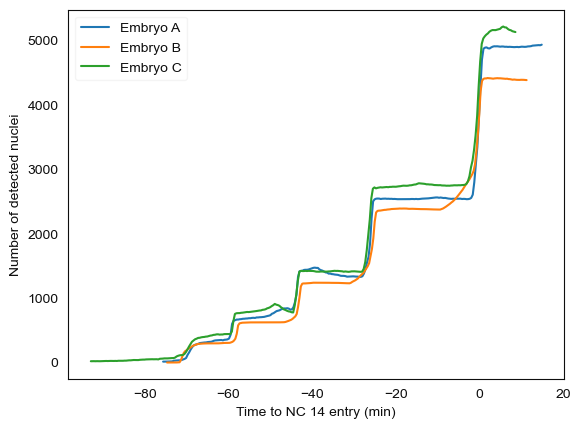

In [4]:
import pwlf

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

time_scales = [
    22,
    20,
    22
]

for i, source in enumerate(sources):
    source_path = Path(source)
    print(source_path.exists())
    spots_df = pd.read_csv(source_path)
    
    spots_df["approx_time"] = spots_df["FRAME"] * (time_scales[i]/60)
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 1]
    
    n_spots = best_spots.groupby("approx_time")["approx_time"].count()
    
    x = n_spots.index
    y = n_spots.values
    # 
    # print(x)
    # 
    my_pwlf = pwlf.PiecewiseLinFit(x,y, degree=0)
    breaks = my_pwlf.fit(7)
    
    best_spots["shifted_time"] = best_spots["approx_time"] - breaks[-2]
    # print(breaks)
    # 
    # x_hat = np.linspace(x.min(), x.max(), 100)
    # y_hat = my_pwlf.predict(x_hat)
    # 
    # slopes = my_pwlf.calc_slopes()    
    # 
    # 
    # plt.plot(x_hat, y_hat, '-', c="black")
    # 
    # for (i, slope) in enumerate(slopes):
    #     # print slope text on plot
    #     xmin, xmax = breaks[i], breaks[i+1]
    #     xmid = (xmin + xmax) / 2
    #     ymid = my_pwlf.predict(xmid)
    #     plt.text(xmid, ymid + 0.5, f"{ymid[0]:.0f}", fontsize=12, color="black", ha="center", va="center")
    
    plt.plot(best_spots.groupby("shifted_time")["shifted_time"].count(), label=f"Embryo {chr(ord('A') + i)}")
    plt.legend()
    plt.xlabel("Time to NC 14 entry (min)")
    plt.ylabel("Number of detected nuclei")
plt.savefig(r"D:\OneDrive - Princeton University\Lab Meetings\stas_duke\num_nuc_time.png", dpi=300, bbox_inches="tight")

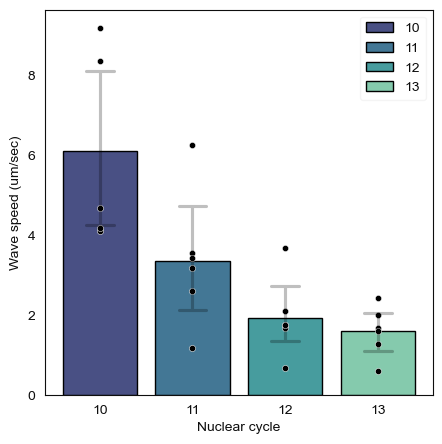

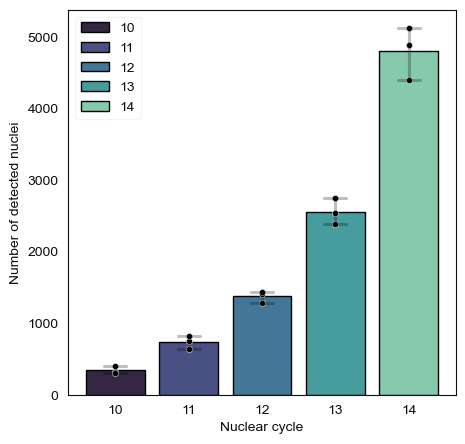

In [5]:
palette = sns.color_palette("mako", n_colors=5)[0:]

stas_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\stas_duke")

waves = pd.read_excel(stas_path/"waves.xlsx")
waves["speed_s"] = waves["speed"] / 60
waves["nc_cat"] = waves["nc"].astype(str)


plt.figure(figsize=(5, 5))
sns.barplot(data=waves, x="nc", y="speed_s", hue="nc", capsize=0.3, err_kws={"c": "#00000040"}, palette=palette[1:],
            edgecolor="black", linewidth=1)
sns.scatterplot(data=waves, x="nc_cat", y="speed_s", s=20, c="black")
plt.xlabel("Nuclear cycle")
plt.ylabel("Wave speed (um/sec)")
plt.grid(False)
plt.savefig(stas_path/"wave_speeds.png", dpi=300, bbox_inches="tight")
plt.show()

num_nuc = pd.read_excel(stas_path/"num_nuc.xlsx")
num_nuc["nc_cat"] = num_nuc["nc"].astype(str)
plt.figure(figsize=(5, 5))
sns.barplot(data=num_nuc, x="nc", y="count", hue="nc", capsize=0.3, err_kws={"c": "#00000040"}, palette=palette,
            edgecolor="black", linewidth=1)
sns.scatterplot(data=num_nuc, x="nc_cat", y="count", s=20, c="black")
plt.xlabel("Nuclear cycle")
plt.ylabel("Number of detected nuclei")
plt.savefig(stas_path/"num_nuc.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
import imageio
from PIL import Image
import napari_animation
import napari
from collections.abc import Iterable

def make_gif_loop(input_path, output_path, color_map_img=None):
    """
    Edits the GIF header to loop indefinitely.
    
    Args:
    input_path (str): Path to the input GIF file.
    output_path (str): Path to save the modified GIF file.
    """
    # try:
    # Open the GIF file using PIL
    with Image.open(input_path) as img:
        # Get the frames and duration
        frames = []
        for i in range(1, img.n_frames):
            img.seek(i)
            frames.append(np.array(img.copy()))
            duration = img.info['duration']
                
        # Save the GIF with loop=0 (infinite loop)
        imageio.mimsave(output_path, frames, duration=duration / 1000, loop=0)
        print(f"GIF saved to {output_path} with infinite loop.")

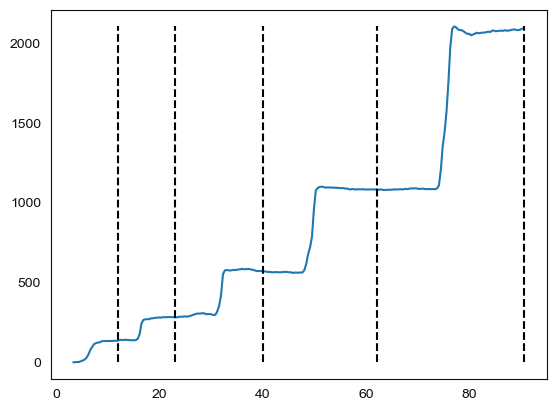

481
694
513
909


100%|██████████| 213/213 [00:38<00:00,  5.51it/s]


In [29]:
import napari
from sklearn.neighbors import NearestNeighbors
import napari_animation

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

palette = sns.color_palette("mako", n_colors=5)[0:]

def to_hex(col):
    if isinstance(col, str):
        return col
    else:
        return "#{:02x}{:02x}{:02x}".format(int(col[0]*255), int(col[1]*255), int(col[2]*255))
    
def get_nn_values(loc, vals, neighbors=5):
    knn = NearestNeighbors(n_neighbors=neighbors)
    knn.fit(loc, vals)
    n = knn.kneighbors(loc, return_distance=False)
    fit_values = vals.values[n]
    fit_values = np.array(np.median(fit_values, axis=1), dtype=int)
    
    return fit_values

palette = [to_hex(x) for x in palette]
choice = 0

source = sources[choice]
source_path = Path(source)
spots_df = pd.read_csv(source_path)
spots_df["approx_time"] = spots_df["FRAME"] * (22/60)

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
final_tracklets = best_spots.groupby("track_id")["FRAME"].max() >= best_spots["FRAME"].max() - 10
best_spots = best_spots[best_spots["track_id"].map(final_tracklets)]
best_spots = best_spots[best_spots["POSITION_Z"] > best_spots["POSITION_X"].mean() + 10]

interphase_dividers = [
    [12, 23, 40, 62, best_spots["approx_time"].max()],
    [18, 29, 46, 68, best_spots["approx_time"].max()],
    [30, 41, 58, 80, best_spots["approx_time"].max()],
][choice]

num_nuc = best_spots.groupby("approx_time")["approx_time"].count()
plt.plot(num_nuc, label=f"Embryo {chr(ord('A') + choice)}")
plt.vlines(interphase_dividers, 0, num_nuc.max(), colors="black", linestyles="dashed")
plt.show()

viewer = napari.Viewer(ndisplay=3)
viewer.theme = "light"
locs = []
colors = []

tracklets = best_spots.groupby("tracklet_id")
ts = tracklets["approx_time"].min()
te = tracklets["approx_time"].max()
fmin = 1000
fmax = 0

for i, (start, end) in enumerate(zip(interphase_dividers[:-1], interphase_dividers[1:])):
    subset = best_spots[(best_spots["approx_time"] >= start) & (best_spots["approx_time"] < end)]
    
    isin_t = ((ts < start) & (ts > start)) ^ ((ts < end) & (te > start))
    isin = subset["tracklet_id"].map(isin_t)
    
    subset = subset[isin]
    loc = subset[["FRAME", "POSITION_X", "POSITION_Y", "POSITION_Z"]]
    locs.append(loc)
    
    new_pt = subset["tracklet_id"].map(ts > start)
    
    tloc = loc.values.copy()
    tloc[:, 0] = tloc[:, 0]*100
    fit_pt = get_nn_values(tloc, new_pt, neighbors=11)
    print(np.sum(fit_pt != new_pt))
    
    color = [palette[i + 1] if x else "#444444" for x in fit_pt]
    # print(color)
    
    fmin = int(min(fmin, np.min(subset["FRAME"])))
    fmax = int(max(fmax, np.max(subset["FRAME"])))
    
    colors.extend(color)

colors = np.array(colors)
locs = np.concatenate(locs)
viewer.add_points(locs, size=12, face_color=colors, border_width=0.2, border_color="black")
viewer.camera.zoom = 0.75
viewer.camera.angles = (0, 90, 90)

wave_img_path = stas_path / f"wave_img_{chr(ord('A') + choice)}"
wave_img_path.mkdir(exist_ok=True)

for frame in tqdm(range(fmin, fmax)):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(wave_img_path / f"wave_frame_{frame}.png", canvas_only=True, scale=2)


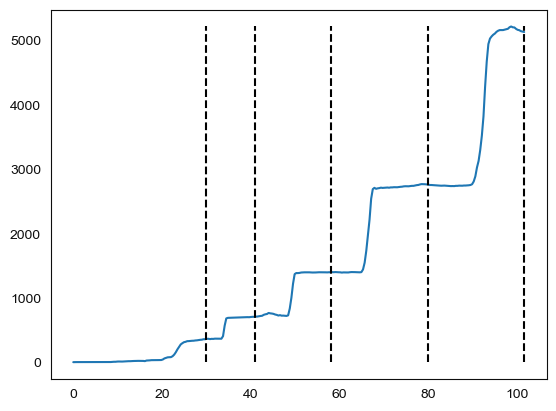

1157
1755
2211
4467
Rendering frames...


  3%|▎         | 6/195 [00:02<01:31,  2.07it/s]


KeyboardInterrupt: 

In [16]:
import napari
from sklearn.neighbors import NearestNeighbors
import napari_animation

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

palette = sns.color_palette("mako", n_colors=5)[0:]

def to_hex(col):
    if isinstance(col, str):
        return col
    else:
        return "#{:02x}{:02x}{:02x}".format(int(col[0]*255), int(col[1]*255), int(col[2]*255))
    
def get_nn_values(loc, vals, neighbors=5):
    knn = NearestNeighbors(n_neighbors=neighbors)
    knn.fit(loc, vals)
    n = knn.kneighbors(loc, return_distance=False)
    fit_values = vals.values[n]
    fit_values = np.array(np.median(fit_values, axis=1), dtype=int)
    
    return fit_values

palette = [to_hex(x) for x in palette]

source = sources[2]
source_path = Path(source)
spots_df = pd.read_csv(source_path)
spots_df["approx_time"] = spots_df["FRAME"] * (22/60)

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
final_tracklets = best_spots.groupby("track_id")["FRAME"].max() >= best_spots["FRAME"].max() - 10
best_spots = best_spots[best_spots["track_id"].map(final_tracklets)]
interphase_dividers = [12, 23, 40, 62, best_spots["approx_time"].max()]
interphase_dividers = [18, 29, 46, 68, best_spots["approx_time"].max()]
interphase_dividers = [30, 41, 58, 80, best_spots["approx_time"].max()]

num_nuc = best_spots.groupby("approx_time")["approx_time"].count()
plt.plot(num_nuc, label=f"Embryo {chr(ord('A') + 2)}")
plt.vlines(interphase_dividers, 0, num_nuc.max(), colors="black", linestyles="dashed")
plt.show()

viewer = napari.Viewer(ndisplay=3)
viewer.theme = "dark"
locs = []
colors = []

tracklets = best_spots.groupby("tracklet_id")
ts = tracklets["approx_time"].min()
te = tracklets["approx_time"].max()
fmin = 1000
fmax = 0

for i, (start, end) in enumerate(zip(interphase_dividers[:-1], interphase_dividers[1:])):
    subset = best_spots[(best_spots["approx_time"] >= start) & (best_spots["approx_time"] < end)]
    
    isin_t = ((ts < start) & (ts > start)) ^ ((ts < end) & (te > start))
    isin = subset["tracklet_id"].map(isin_t)
    
    subset = subset[isin]
    loc = subset[["FRAME", "POSITION_X", "POSITION_Y", "POSITION_Z"]]
    locs.append(loc)
    
    new_pt = subset["tracklet_id"].map(ts > start)
    
    tloc = loc.values.copy()
    tloc[:, 0] = tloc[:, 0]*100
    fit_pt = get_nn_values(tloc, new_pt, neighbors=11)
    print(np.sum(fit_pt != new_pt))
    
    color = [palette[i + 1] if x else "#444444" for x in fit_pt]
    # print(color)
    
    fmin = int(min(fmin, np.min(subset["FRAME"])))
    fmax = int(max(fmax, np.max(subset["FRAME"])))
    
    colors.extend(color)

colors = np.array(colors)
locs = np.concatenate(locs)
viewer.add_points(locs, size=12, face_color=colors)

napari.run()
# 
anim = napari_animation.Animation(viewer)
viewer.dims.set_point(0, fmin)
anim.capture_keyframe(steps=1)
viewer.dims.set_point(0, fmax)
anim.capture_keyframe(steps=fmax-fmin)    

anim.animate(filename='tmp_out.gif', fps=24, scale_factor=1)
make_gif_loop('tmp_out.gif', stas_path/"waves.gif")


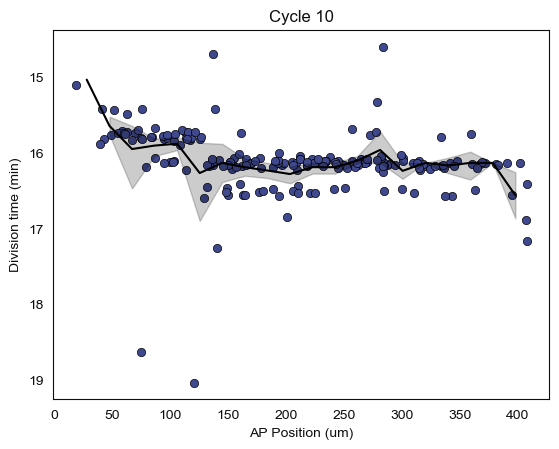

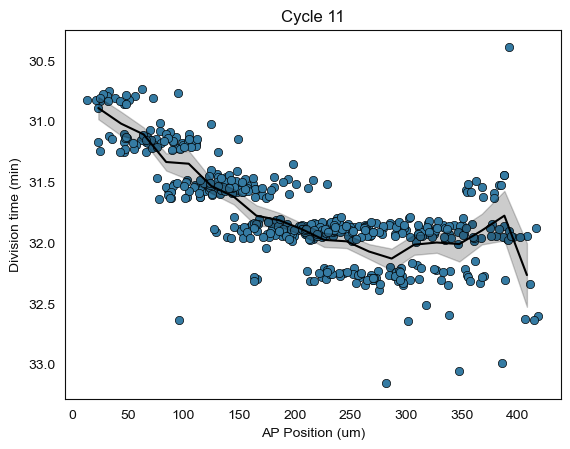

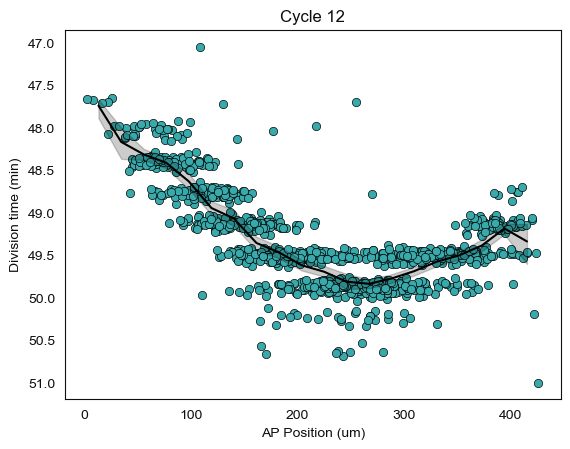

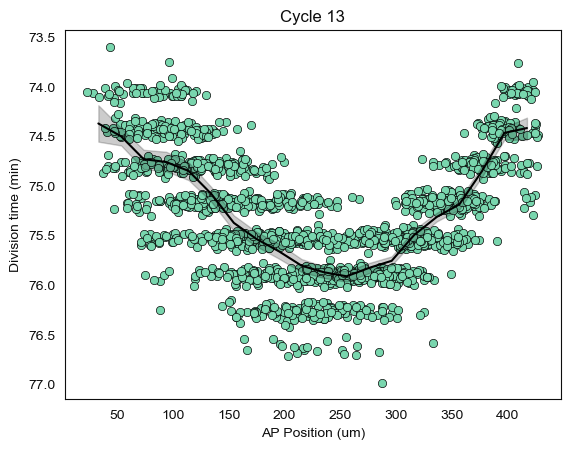

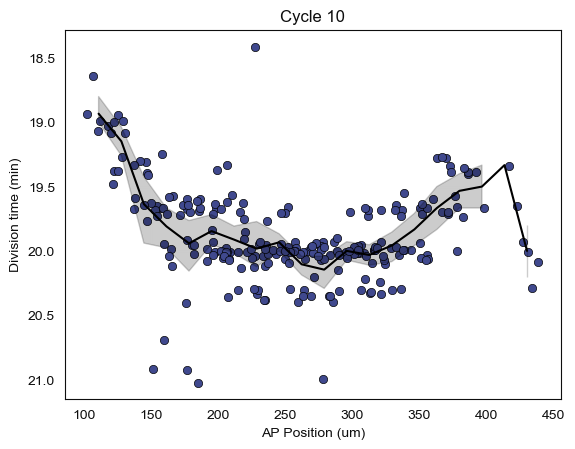

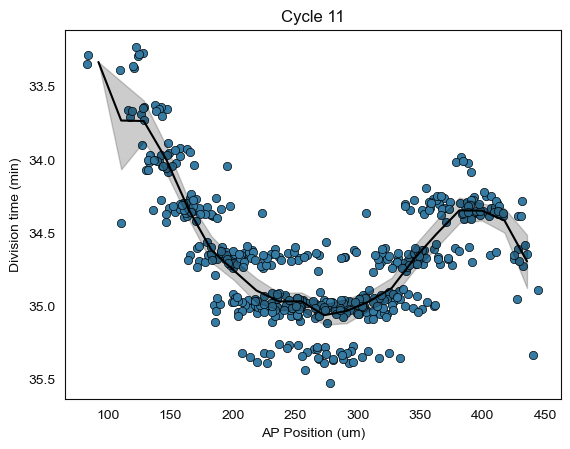

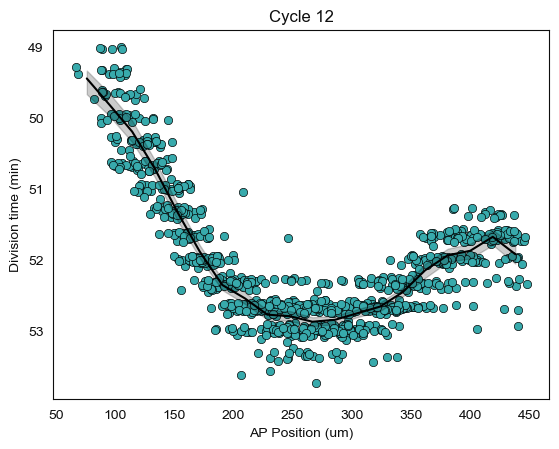

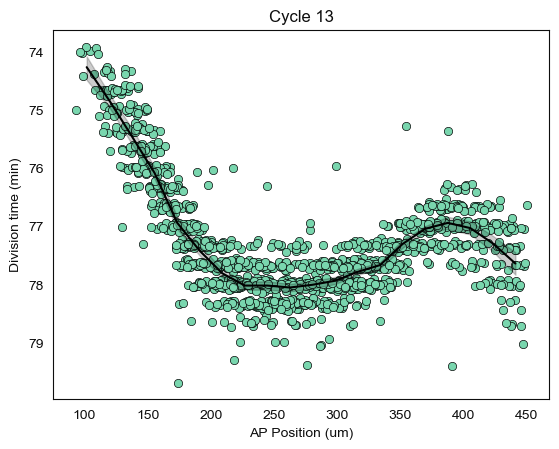

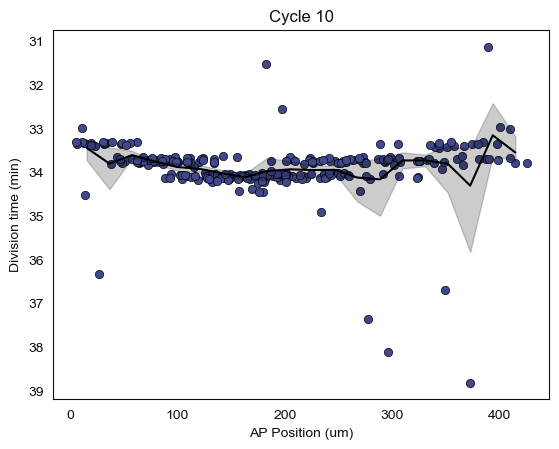

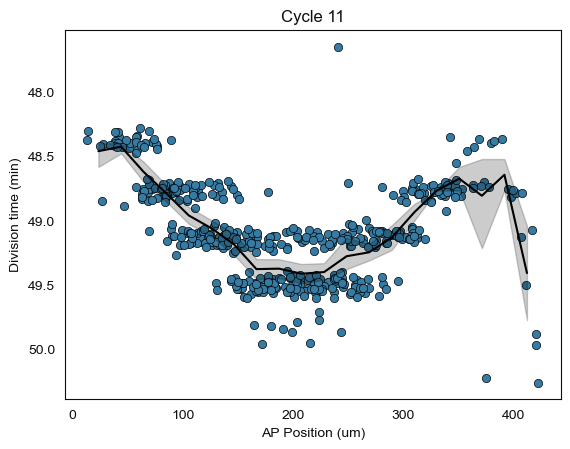

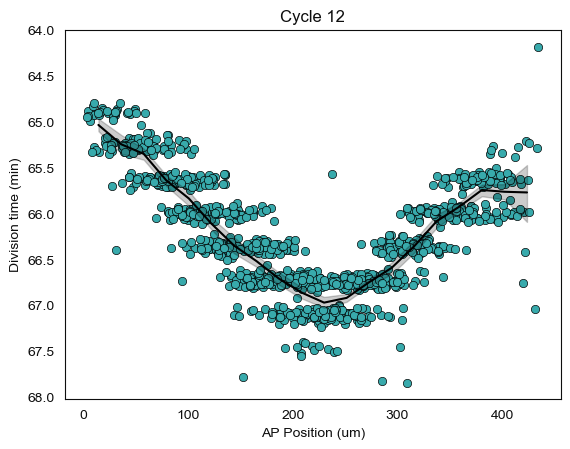

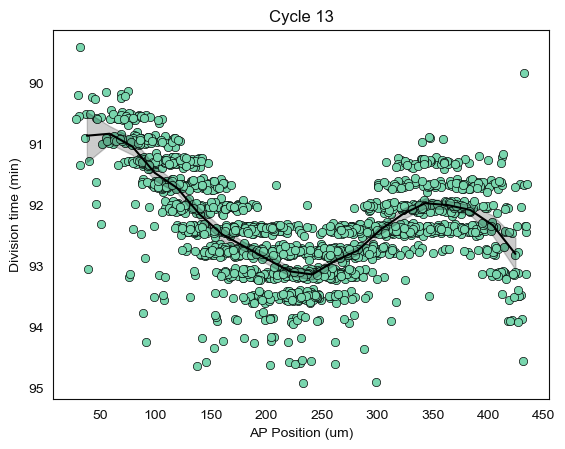

In [55]:
palette = sns.color_palette("mako", n_colors=5)[0:]

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

interphase_dividers = [
    [12, 23, 40, 62, 150],
    [18, 29, 46, 68, 150],
    [30, 41, 58, 80, 150],
]

time_factor = [
    22,
    20,
    22
]

ap_multipliers = [
    -1, 
    -1, 
    -1,
]

def jitter(x, factor=0.05):
    return x + factor*np.random.randn(len(x))


x = "AP"
y = "time_end"

for choice, source in enumerate(sources):
    source_path = Path(source)
    spots_df = pd.read_csv(source_path)
    save_path = stas_path / f"end_time_{chr(ord('A') + choice)}"
    save_path.mkdir(exist_ok=True)
    
    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0] * ap_multipliers[choice]
    spots_df["AP"] = spots_df["AP"] - np.quantile(spots_df["AP"], 0.01)
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    spots_df["approx_time"] = spots_df["FRAME"] * (time_factor[choice]/60)
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 7]
    
    best_spots = best_spots[best_spots["AP"] > 0]
    best_spots = best_spots[best_spots["AP"] < np.quantile(best_spots["AP"], 0.99)]
    
    final_tracklets = best_spots.groupby("track_id")["FRAME"].max() >= best_spots["FRAME"].max() - 10
    best_spots = best_spots[best_spots["track_id"].map(final_tracklets)]
    
    interphase_divider = interphase_dividers[choice]
    
    def cycle_classifier(time):
        return np.argmax(np.array(interphase_divider) > time)
    
    tracklets = best_spots.groupby("tracklet_id")
    tdf = dict()
    tdf["cycle"] =  tracklets["approx_time"].min().apply(cycle_classifier)
    tdf["track_id"] = tracklets["track_id"].first()
    tdf["time_start"] = tracklets["approx_time"].min()
    tdf["time_end"] = tracklets["approx_time"].max()
    tdf["cycle_length"] = tdf["time_end"] - tdf["time_start"]
    tdf["y"] = tracklets["y"].first()
    tdf["AP"] = tracklets["AP"].first()
    
    tracklets = pd.DataFrame(tdf)
    
    for cycle in range(0, 4):
        t = tracklets[tracklets["cycle"] == cycle]
        k = 1.5
        for factor in ["time_end", "cycle_length", "time_start"]:
            factor_mean = t[factor].mean()
            factor_std = t[factor].std()
            # print(start_mean - k*start_std, start_mean + k*start_std)
            t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        
        sns.scatterplot(x=jitter(t[x]), y=jitter(t[y]), color=palette[cycle + 1], edgecolors="k")
        plt.gca().invert_yaxis()
        plt.title(f"Cycle {cycle + 10}")
        plt.xlabel("AP Position (um)")
        plt.ylabel("Division time (min)")
        x_binned = [(a.right + a.left)/2 for a in pd.cut(t[x], bins=20)]
        sns.lineplot(x=x_binned, y=t[y], color="black")
        # sns.lineplot(t, x="AP", y="time_start", color=palette[cycle], alpha=0.5)
        plt.savefig(save_path /f"wave_cycle_{cycle}.png", dpi=300, bbox_inches="tight")
        plt.show()
    # sns.histplot(tracklets, x="time_start", hue="cycle", bins=20, discrete=True)
    # plt.show()

In [64]:
import napari
from sklearn.neighbors import NearestNeighbors
import napari_animation

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

# palette = sns.color_palette("mako", n_colors=5)[0:]
palette = create_palette(500)

def to_hex(col):
    if isinstance(col, str):
        return col
    else:
        return "#{:02x}{:02x}{:02x}".format(int(col[0]*255), int(col[1]*255), int(col[2]*255))
    
# def get_nn_values(loc, vals, neighbors=5):
#     knn = NearestNeighbors(n_neighbors=neighbors)
#     knn.fit(loc, vals)
#     n = knn.kneighbors(loc, return_distance=False)
#     fit_values = vals.values[n]
#     fit_values = np.array(np.median(fit_values, axis=1), dtype=int)
#     
#     return fit_values

palette = [to_hex(x) for x in palette]
choice = 0

source = sources[choice]
source_path = Path(source)
spots_df = pd.read_csv(source_path)
spots_df["approx_time"] = spots_df["FRAME"] * (22/60)

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
final_tracklets = best_spots.groupby("track_id")["FRAME"].max() >= best_spots["FRAME"].max() - 10
best_spots = best_spots[best_spots["track_id"].map(final_tracklets)]
best_spots = best_spots[best_spots["POSITION_Z"] > best_spots["POSITION_X"].mean() + 10]

# interphase_dividers = [
#     [12, 23, 40, 62, best_spots["approx_time"].max()],
#     [18, 29, 46, 68, best_spots["approx_time"].max()],
#     [30, 41, 58, 80, best_spots["approx_time"].max()],
# ][choice]


viewer = napari.Viewer(ndisplay=3)
viewer.theme = "light"

fmin = 1000
fmax = 0

loc = np.array(best_spots[["FRAME", "POSITION_X", "POSITION_Y", "POSITION_Z"]])

color = [palette[x % 500] for x in best_spots["track_id"]]
fmin = np.min(best_spots["FRAME"])
fmax = np.max(best_spots["FRAME"])

colors = np.array(color)

viewer.add_points(loc, size=13, face_color=colors, border_width=0.125, border_color="black", antialiasing=0)
viewer.camera.zoom = 0.75
viewer.camera.angles = (0, 90, 90)

wave_img_path = stas_path / f"glasbey_{chr(ord('A') + choice)}"
wave_img_path.mkdir(exist_ok=True)

for frame in tqdm(range(160, int(fmax))):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(wave_img_path / f"glasbey_frame_{frame}.png", canvas_only=True, scale=8)

100%|██████████| 87/87 [03:11<00:00,  2.20s/it]
